In [81]:
import sys,os
import uproot4 as uproot
import awkward1 as ak
import json
import numpy as np
import matplotlib.pyplot as plt
from fcc_python_tools.locations import loc
from fcc_python_tools import kinematics
from particle import literals as lp
from fcc_python_tools import plotting
import tensorflow as tf
import zfit
import random

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})
rc('text', usetex=True)

file_type = "p8_ee_Zcc_ecm91_EvtGen_D2PiPi0"

#Load 1 sub-file of 100k events
file = uproot.open(f"/eos/experiment/fcc/ee/generation/DelphesEvents/fcc_tmp/{file_type}/events_163459820.root")
tree = file['events']

#Get all the variables in the tree
vars = tree.keys()

#Loacation of the reco particles
r_container = "ReconstructedParticles"
r_c = f'{r_container}/{r_container}'

#Keep the variables that aren't covMatrix
keep_vars = []
for v in vars:
    if("covMatrix" not in v and r_c in v):
        keep_vars.append(v)

n_keep = 50000

r = tree.arrays(keep_vars,how="zip")[:n_keep]

In [82]:
r[r_c,'p'] = kinematics.calc_p(r,r_c)
p_cut = r[r_c,"p"] > 2.
r = r[p_cut]

#Pions
pi_cut = abs(r[r_c,"mass"] - lp.pi_plus.mass/1000.) < 1e-4
r["pi"] = r[r_c][pi_cut]

#Photons
gamma_cut = abs(r[r_c,"mass"] - lp.gamma.mass/1000.) < 1e-4
r["gamma"] = r[r_c][gamma_cut]

In [83]:
#Combine photons to make pi0
pi0 = ak.combinations(r["gamma"],2)
pi0["gamma_1"], pi0["gamma_2"] = ak.unzip(pi0)

#Angle between photons, to check degree of colinearity and reduce background
pi0["gamma_angle"] = kinematics.cos_angle(pi0["gamma_1"], pi0["gamma_2"])

pi0_angle_cut = pi0["gamma_angle"] > 0.9
pi0 = pi0[pi0_angle_cut]

PDG_gamma_m = lp.gamma.mass/1000.
pi0["mass"] = kinematics.mass([pi0["gamma_1"], pi0["gamma_2"]], [PDG_gamma_m, PDG_gamma_m])

PDG_pi0_m = lp.pi_0.mass/1000.
pi0_window = 0.1
pi0_cut = abs(pi0["mass"] - PDG_pi0_m) < pi0_window
pi0 = pi0[pi0_cut]

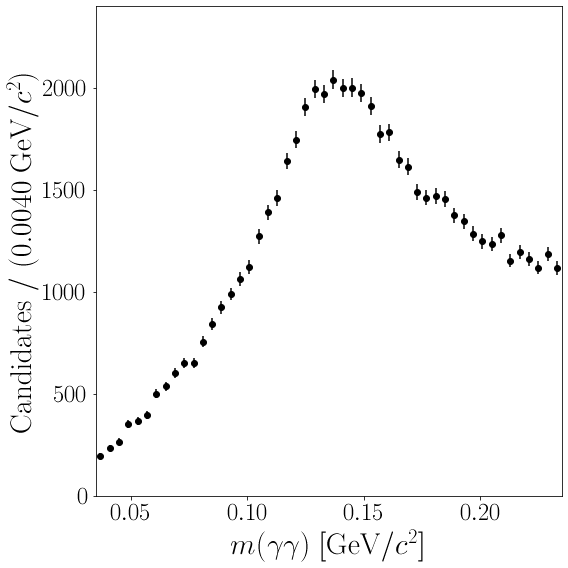

In [84]:
plotting.errorbar_hist(pi0,"mass",f"{file_type}_Pi0_M","$m(\\gamma \\gamma)$","GeV/$c^2$",PDG_pi0_m-pi0_window,PDG_pi0_m+pi0_window,50)

In [85]:
D = ak.cartesian({"pi": r["pi"], "pi0_gamma_1": pi0["gamma_1"], "pi0_gamma_2": pi0["gamma_2"]})

PDG_pi_m = lp.pi_plus.mass/1000.
PDG_pi0_m = lp.pi_0.mass/1000.
mass = kinematics.mass([D["pi"], D["pi0_gamma_1"], D["pi0_gamma_2"]], [PDG_pi_m, PDG_gamma_m, PDG_gamma_m])

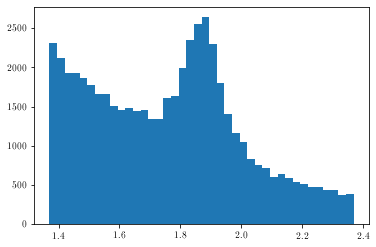

In [86]:
PDG_D_m = lp.D_plus.mass/1000.
window = 0.5
mass_cut = abs(mass - PDG_D_m) < window
mass = mass[mass_cut]

plt.hist(ak.flatten(mass),bins=40)
plt.show()

In [87]:
low = PDG_D_m - window
high = PDG_D_m + window
obs = zfit.Space('mD', limits=(low, high))

#Signal PDF
rand = random.randint(0,9999)
mu = zfit.Parameter(f"mu_{rand}", 1.87, low, high)
sigmaL = zfit.Parameter(f"sigmaL_{rand}", 0.1, 0., 0.5)
sigmaR = zfit.Parameter(f"sigmaR_{rand}", 0.05, 0., 0.5)
alphaL = zfit.Parameter(f"alphaL_{rand}", 4., 0., 10.)
nL = zfit.Parameter(f"nL_{rand}", 100., 0., 200.)
alphaR = zfit.Parameter(f"alphaR_{rand}", -1., -5., 0.)
nR = zfit.Parameter(f"nR_{rand}", 100., 0., 200.)
frac = zfit.Parameter(f"frac_{rand}", 0.4, 0., 1.)

n_sig = zfit.Parameter(f"n_sig_{rand}", 10000, 0., 50000.)

pdf_sigL = zfit.pdf.CrystalBall(obs=obs, mu=mu, sigma=sigmaL, alpha=alphaL, n=nL)
pdf_sigR = zfit.pdf.CrystalBall(obs=obs, mu=mu, sigma=sigmaR, alpha=alphaR, n=nR)
pdf_sig = zfit.pdf.SumPDF([pdf_sigL, pdf_sigR], frac).create_extended(n_sig)

#Background PDF
lam = zfit.Parameter(f"lam_{rand}", -1.8, -10, 0.)

n_bkg = zfit.Parameter(f"n_bkg_{rand}", 30000., 0., 100000.)

pdf_bkg = zfit.pdf.Exponential(obs=obs, lam=lam).create_extended(n_bkg)

#Total PDF
pdf = zfit.pdf.SumPDF([pdf_sig, pdf_bkg])

In [88]:
data_np = ak.to_numpy(ak.flatten(mass))
data = zfit.Data.from_numpy(obs=obs, array=data_np)

In [89]:
nll = zfit.loss.ExtendedUnbinnedNLL(model=pdf, data=data)
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll)
params = result.params

#param_errors, _ = result.errors(method="minuit_minos")
param_errors = result.hesse()

print("m(D) fit function minimum:", result.fmin)
print("m(D) fit converged:", result.converged)
print("m(D) fit full minimizer information:", result.info)

params = result.params
print(params)

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -5.362e+05                 │      Ncalls = 1928 (1928 total)      │
│ EDM = 6.17e+03 (Goal: 0.001)     │               up = 0.5               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│INVALID Minimum│ Valid Parameters │       SOME Parameters at limit       │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           ABOVE call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │APPROXIMATE│  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
m(D) fit function minimum: -536161.897800028
m(D) fit converged: False
m(D) fit full minimizer information: {'n_eval': 1928, 'n_iter': 1928, 'original': FMin(fval=-536161.897800028, edm=6173.221207662818, tolerance=1.0, nfcn=1928, ncalls=19

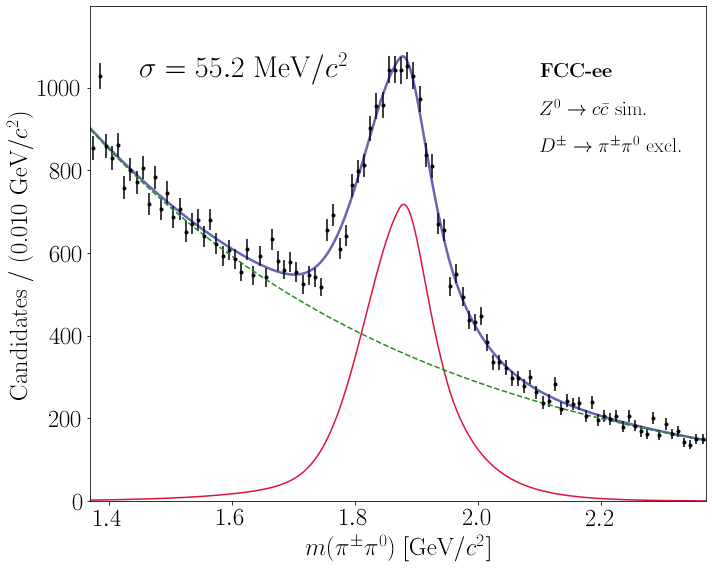

In [92]:
fig,ax = plt.subplots(figsize=(10,8))
lower, upper = obs.limits
low = lower[-1][0]
high = upper[0][0]
bin_width = 0.01
bins = int(float(high - low)/bin_width)
counts, bin_edges = np.histogram(data_np, bins, range=(low,high))
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
err = np.sqrt(counts)
plt.errorbar(bin_centres, counts, yerr=err, fmt='o', markersize=3, color='black')
x_plot = np.linspace(low, high, num=1000)
y_plot_tot = zfit.run(pdf.pdf(x_plot, norm_range=obs))
plt.plot(x_plot, y_plot_tot*len(data_np)/bins*obs.area(), color='navy', linewidth=2.5, alpha=0.6)
y_plot_sig = zfit.run(pdf_sig.pdf(x_plot, norm_range=obs))
plt.plot(x_plot,y_plot_sig*params[n_sig]['value']/bins*obs.area(), color='crimson')
y_plot_bkg = zfit.run(pdf_bkg.pdf(x_plot, norm_range=obs))
plt.plot(x_plot,y_plot_bkg*params[n_bkg]['value']/bins*obs.area(), color='forestgreen', linestyle='dashed')
ax.tick_params(axis='both', which='major', labelsize=25)
plt.ylabel("Candidates / (%.3f GeV/$c^2$)" % bin_width,fontsize=25)
plt.xlabel("$m(\pi^\pm \pi^0)$ [GeV/$c^2$]",fontsize=25)
plt.xlim(low,high)
ymin, ymax = plt.ylim()
plt.ylim(0,1.05*ymax)
plt.text(2.1,0.9*ymax,"\\textbf{FCC-ee}",fontsize=20)
plt.text(2.1,0.82*ymax,"$Z^0 \\to c \\bar{c}$ sim.",fontsize=20)
plt.text(2.1,0.74*ymax,"$D^\pm \\to \pi^\pm \pi^0$ excl.",fontsize=20)
sigmaL_val = 1000.*params[sigmaL]['value']
sigmaR_val = 1000.*params[sigmaR]['value']
frac_val = params[frac]['value']
sigma_val = frac_val*sigmaL_val + (1-frac_val)*sigmaR_val
plt.text(1.45,0.9*ymax,"$\\sigma = %.1f$ MeV/$c^2$" % sigma_val,fontsize=30)
plt.tight_layout()
fig.savefig(loc.PLOTS+f"/{file_type}_D_M_fit.pdf")

In [91]:
#Number of Z's produced per year (4) per experiment (2)
N_Z = 3e12 * 0.25 * 0.5
#Number of c quarks produced
N_c = 2 * 0.1203 * N_Z
#Number of D -> pi pi0 produced (assume 43% production, same as for B mesons)
N_D2PiPi0 = N_c * 0.43 * 1.247e-3

print("N expected per year per exp = %.3e" % N_D2PiPi0)

N expected per year per exp = 4.838e+07
